# measuring resource usage and profiling of python code
----------------------------------------------


The first step of any code optimization process should be measuring what your code is doing, in order to pinpoint where your effort should be focused.


In [1]:
%load_ext autoreload
%autoreload 2

<br>

# Table of Content <a id='toc'></a>

0. [meet the code](#0)

1. [timing](#2)
 
 1.1 [timing a single object](#1.1)
 
 1.2 [timing a set of lines](#1.2)
 
 1.3 [profiling](#1.3)
 
2. [measuring RAM usage](#3)

2.1 [line-by-line memory](#2.1)

2.2 [time-based memory usage](#2.2)

<br>
<br>

# 0. Meet the code <a id='0'></a>
----------------------------------------------------------

In this notebook we will mostly focus on a simple function which computes pairwise distance between a set of vectors, a very classical operation present in many data analysis methods.

In [84]:
def pairwise_distance(X):

    num_vectors = len(X)
    num_measurements = len(X[0])
    D = [[0]*num_vectors for x in range(num_vectors)]
    
    for i in range(num_vectors):
        for j in range(num_vectors):
            d = []
            for k in range(num_measurements):
                d.append( ( X[i][k] - X[j][k] )**2 )
            
            D[i][j] = sum(d) **0.5
    return(D)

In [15]:
import numpy as np

## let's generate some random data to play with : 200x100 matrix
num_vector = 200
num_measures = 100

data = np.random.uniform(size=(num_vector,num_measures))
print(data)
print(data.shape)

[[0.3816928  0.7146188  0.74749338 ... 0.21755177 0.85776353 0.72067249]
 [0.36266854 0.59501446 0.11200892 ... 0.95350207 0.56230793 0.54288617]
 [0.5864311  0.91123864 0.28301761 ... 0.40731974 0.46131536 0.03407488]
 ...
 [0.64302633 0.61370854 0.14247122 ... 0.94878887 0.84392165 0.28757554]
 [0.45937428 0.29125475 0.63860882 ... 0.98284744 0.28490457 0.07783631]
 [0.58897308 0.02194784 0.28411767 ... 0.34752908 0.26589814 0.93058798]]
(200, 100)


We also need to generate some data for another example later on:

In [10]:
%%time
import numpy as np

## 1,000,000 random sequences of 500 nucleotides 
with open('data/large_file.fas' , 'w') as OUT :
    for i in range(1000000):
        print('>seq{}'.format(i),file=OUT)
        s = ''.join(np.random.choice(list("ATGC") , size=500))
        print(s,file=OUT)

## 500 random sequences of 500 nucleotides 
with open('data/medium_file.fas' , 'w') as OUT :
    for i in range(500):
        print('>seq{}'.format(i),file=OUT)
        s = ''.join(np.random.choice(list("ATGC") , size=500))
        print(s,file=OUT)


CPU times: user 2min 8s, sys: 979 ms, total: 2min 9s
Wall time: 2min 9s


<br>
<br>

[back to the toc](#toc)

# 1. Measuring time usage <a id='2'></a>


## 1.1 timing a single object <a id='1.1'></a>

On you terminal, you may measure up the time taken by a python script execution using:

`time python myscript.py`

Or, using jupyter/ipython magic :

In [16]:
%time D = pairwise_distance(data)

CPU times: user 3.24 s, sys: 3.99 ms, total: 3.25 s
Wall time: 3.24 s


Or : 

In [17]:
%%time 
## applies on the whole cell

D = pairwise_distance(data)


CPU times: user 3.14 s, sys: 0 ns, total: 3.14 s
Wall time: 3.14 s


That is all nice, but there is always a bit a variability, which becomes very apparent on smaller time.

In [18]:
# smaller data set
num_vector = 100
num_measures = 10

data = np.random.uniform(size=(num_vector,num_measures))

%time D = pairwise_distance(data)

CPU times: user 103 ms, sys: 13 µs, total: 103 ms
Wall time: 100 ms


For this, we have `timeit`:

`python -m timeit myScript.py`

Or :

In [19]:
%timeit D = pairwise_distance(data)

86.6 ms ± 4.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
# you can specify the number of runs and loops performed
%timeit -n 2 -r 10 D = pairwise_distance(data)

85.6 ms ± 4.32 ms per loop (mean ± std. dev. of 10 runs, 2 loops each)


Performs `-r` runs, each time taking the best execution time out of `-n` loops.

**Question:** why takes the "best" out of n loops?

Ok, already this is nice, we will definitely be using this to compare together different implementations.

For example, I have rewritten the function using numpy :

In [21]:

def pairwise_distance_numpy(X):

    num_vectors = X.shape[0]
    num_measurements = X.shape[1] 
    D = np.empty((num_vectors, num_vectors), dtype=np.float64)
    
    for i in range(num_vectors):
        for j in range(num_vectors):
            d = np.square( np.subtract(X[i], X[j]) )
            D[i, j] = np.sqrt(np.sum(d))
    return(D)

In [22]:
# 100x100 data set
num_vector = 100
num_measures = 100

data = np.random.uniform(size=(num_vector,num_measures))

print('native:')
%timeit -n 5 -r 3 D = pairwise_distance(data)
print('numpy:')
%timeit -n 5 -r 3 D = pairwise_distance_numpy(data)

native:
717 ms ± 66.4 ms per loop (mean ± std. dev. of 3 runs, 5 loops each)
numpy:
54.1 ms ± 264 µs per loop (mean ± std. dev. of 3 runs, 5 loops each)


Nice! 

**Trick** : grabbing the results of `%timeit` in a variable : `-o`

In [26]:
timeit_res = %timeit -n 5 -r 3 -o D = pairwise_distance_numpy(data)
print("average:",timeit_res.average , 'standard-dev', timeit_res.stdev )

91.2 ms ± 11.3 ms per loop (mean ± std. dev. of 3 runs, 5 loops each)
average: 0.09116586793679744 standard-dev 0.01131013592654897


That is a neat trick to help us investigate how execution time evolves with the data size:

In [50]:
%%time
avgTimes = []

num_measures = 10
num_vector_list = range( 10,200,10 )

for num_vector in num_vector_list:
    data = np.random.uniform(size=(num_vector,num_measures))
    
    ## here I also use the -q option to suppress the text output
    timeit_res = %timeit -n 2 -r 7 -o -q D = pairwise_distance_numpy(data)
    avgTimes.append(timeit_res.average)


CPU times: user 29.4 s, sys: 19 µs, total: 29.4 s
Wall time: 29.4 s


Text(0, 0.5, 'time(s)')

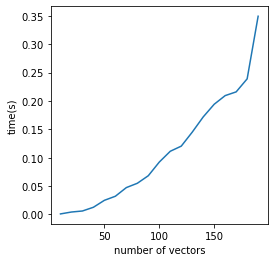

In [51]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(num_vector_list,avgTimes )

ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')

plt.xlabel("number of vectors")
plt.ylabel("time(s)")


**Question:** What do you think about the shape of this curve? Was this expected?

<br>

[back to ToC](#toc)

## 1.2 timing a set of lines<a id='1.2'></a>


Sometimes you will want to measure the execution time of a particular step in you code, but it may not be easy to isolate it for a usage with `time` or `timeit`.

For instance, consider the following code which reads a [fasta file](https://en.wikipedia.org/wiki/FASTA_format) and computes the [GC content](https://en.wikipedia.org/wiki/GC-content) of each sequence:

In [11]:
%%time
GC=[]

with open('data/large_file.fas' , 'r') as IN :
    for l in IN:
        if not l.startswith(">"):
            GC.append( (l.count('C')+l.count('G'))*100/len( l.strip() ) )


CPU times: user 4.37 s, sys: 132 ms, total: 4.51 s
Wall time: 4.51 s


The codes takes about 4.5s to complete, but how much of this is file reading, and how much is GC content computation ?

Here we do not really want to re-write the code to have neatly separated steps to apply `%time` on (+ we may not be able store all the sequences in memory)


In these situation, the `time()` function from module `time` (so, `time.time()`) is quite useful.

In [40]:
import time
time.time()

1657284318.4993396

It returns the time (in second) since the Epoch, which is 00:00:00 on 1 January 1970.

Applied to our code:

In [54]:
GC=[]

TotTime=0
GCtime=0


with open('data/large_file.fas' , 'r') as IN :
    
    start = time.time()
    for l in IN:
        if not l.startswith(">"):
            t1 = time.time()
            GC.append( (l.count('C')+l.count('G'))*100/len( l.strip() ) )
            t2 = time.time()
            GCtime += t2 -t1
    stop = time.time()
TotTime = stop-start
print("Total : {:.3f}s".format(TotTime))
print("  GC% : {:.3f}s".format(GCtime))
print(" read : {:.3f}s".format(TotTime- GCtime))

Total : 5.471s
  GC% : 4.288s
 read : 1.183s


<br> 

[back to ToC](#toc)

## 1.3 profiling<a id='1.3'></a>


Most of the time your code is more complex than a single function, and before optimizing you first want to see which function you should optimize. That is when **profiling** comes in handy.

For instance, consider the following code, which reads sequences from a fasta file, sort them by GC content, then computes a matrix of pairwise distance between all sequences and finally writes this matrix to a file.

In [59]:

def read_fasta(filename):
    """reads a fasta file and reutrns its sequences as a dictionnary"""
    Dseq={}
    curseq = ''
    cur = ''
    with open(filename,'r') as IN:
        for l in IN:
            if l.startswith(">"):
                if cur !='':
                    Dseq[cur] = curseq
                cur = l[1:].strip()
                curseq = ''
            else:
                curseq += l.strip()
        if cur != '':
            Dseq[cur] = curseq
    return Dseq
            

def computeGC( seq ):
    """takes a sequence (str) and compute it GC% (float)"""
    gc=0
    for i in range(len(seq)):
        if seq[i] in "GC":
            gc += 1
    return 100*gc / len(seq)

def computeGC_dict( Dseq ):
    """takes a dictionnary containing sequences as values 
        and compute a dictionnary containing their GC%"""
    Dgc = {}
    for k in Dseq:
        Dgc[k] = computeGC(Dseq[k])
    return Dgc

def compute_sequence_similarity(seqA  ,seqB):
    """compute similarity between 2 sequence as the fraction of position where they have the same value"""

    l = len(seqA)
    similar = 0
    for i in range(l):
        if seqA[i] == seqB[i]:
            similar += 1
    return similar/l



def mainScript(input_filename , output_filename):
    
    # step 1 : read fasta
    Dseq = read_fasta(input_filename)
    
    # step 2 : compute GC%
    Dgc = computeGC_dict( Dseq )
    
    # step 3 : sort by GC
    ordered_seq = sorted( Dgc.keys() , key= lambda x : Dgc[x] )
    
    # step 4 : compute pairwise distance matrix
    sim = np.zeros( ( len(Dseq),len(Dseq) ) )
    for i,s1 in enumerate(ordered_seq):
        for j,s2 in enumerate(ordered_seq):
            sim[i,j] = compute_sequence_similarity( Dseq[s1] , Dseq[s2] )

    # step 5 : write the matrix
    with open(output_filename,'w') as OUT:
        print(','.join(ordered_seq), file=OUT)
        for i in range(len(ordered_seq)):
            print( *(sim[i]) , sep=',',file=OUT )

    
    

Now, if you have the eye for it, it looks like most of these function could be rewritten to be faster.

For instance, the function to compute the GC%:

In [62]:
def computeGC_better( seq ):
    """takes a sequence (str) and compute it GC% (float)"""
    return 100*(seq.count('G')+seq.count('C')) / len(seq)

seq = "ATGC"*5000
%timeit -n 100 -r 10 computeGC(seq)
%timeit -n 100 -r 10 computeGC_better(seq)

1.42 ms ± 97.8 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)
25.4 µs ± 4.3 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


That is a commendable speedup!

But, considering coding time is a finite ressouce, where should we start?

Where is out effort better spent?



We recommend using [cProfile](https://docs.python.org/3/library/profile.html)

in the terminal :

```
python -m cProfile -o profile.log -s cumtime myScript.py
```

will execute the script, and profile time usage of every functions
 * `-o` : output file for the profiling log
 * `-s cumtime` : to sort by cumulative time spent in a single function

in jupyter :

In [63]:
%prun -l 30 -s cumtime  mainScript( 'data/medium_file.fas' ,'test.out') 
# the %prun magic command activate profiling
#  -l 30 : limits the report to 30 lines
#  -s cumtime : sort by decreasing cumtime


The columns correspond to:
 * ncalls : for the number of calls.
 * tottime : for the total time spent in the given function (and excluding time made in calls to sub-functions)
 * percall : is the quotient of tottime divided by ncalls
 * cumtime : is the cumulative time spent in this and all subfunctions (from invocation till exit). This figure is accurate even for recursive functions.
 * percall : is the quotient of cumtime divided by primitive calls


### Micro-Exercise:
* Look at the profile. Where should optimization efforts go first ? What would be the effect of using our better implementation of the GC% computing function ?

<br>
<br>

So now you have tools to help you diagnose which part of your cod the most time. But, before we move on to optimization, let's see what would happen if we launched out code on a larger dataset:


In [64]:
%time mainScript( 'data/large_file.fas' ,'test.out') 

MemoryError: Unable to allocate 7.28 TiB for an array with shape (1000000, 1000000) and data type float64

So here the problem is not the execution time, but the RAM usage. 

While time is a somewhat flexible constraint (it is always possible to wait a bit longer), memory is a hard limit : you either make your code less memory-hungry, or you move to another computer...

So le'ts focus on memory now

<br>
<br>

[back to the toc](#toc)

# 2. measuring RAM usage <a id='3'></a>

## 2.1 line-by-line memory <a id='2.1'></a>

Sometimes, you also want to measure the memory imprint of your code 

The nicest tool I know about for that is [memory-profiler](https://pypi.org/project/memory-profiler/)

Install it with :

```python
!pip install memory_profiler
```

Basically, in your code you add a **decorator** to the function of interest:

In [65]:
from memory_profiler import profile

@profile
def my_func():
    a = [1] * (10 ** 6)
    b = [2] * (2 * 10 ** 7)
    del b
    return a

Then, you may either do it command-line style  :

```
python -m memory_profiler example.py
```

or prefer jupyter-magic:

In [66]:
%load_ext memory_profiler

In [70]:
%memit _=my_func()

ERROR: Could not find file /tmp/ipykernel_8200/3712895371.py
ERROR: Could not find file /tmp/ipykernel_8200/3712895371.py
peak memory: 1208.07 MiB, increment: 160.19 MiB


It gives us a result: `peak memory: 210.19 MiB, increment: 152.58 MiB`
            
But it does not like that our code is in the same notebook. Let's have it in another script :

In [72]:
from utils import my_func

_=my_func()

Filename: /home/wandrille/Documents/trainingProjects/intermediate_python/intermediate-python-training/course2/utils.py

Line #    Mem usage    Increment  Occurrences   Line Contents
     5   1055.5 MiB   1055.5 MiB           1   @profile
     6                                         def my_func():
     7   1055.6 MiB      0.1 MiB           1       a = [1] * (10 ** 6)
     8   1208.2 MiB    152.6 MiB           1       b = [2] * (2 * 10 ** 7)
     9   1055.7 MiB   -152.5 MiB           1       del b
    10   1055.7 MiB      0.0 MiB           1       return a




Now, that is quite nice : we have a run down of the RAM usage, line-by-line.

Let's see how that works for our `pairwise_distance` function:

In [98]:
%%writefile tmp.py
import numpy as np
from memory_profiler import profile

## the memory increments are fairly small here, so I set the precision higher
@profile(precision=3)
def pairwise_distance_profile(X):

    num_vectors = len(X)
    num_measurements = len(X[0])
    D = [[0]*num_vectors for x in range(num_vectors)]
    
    for i in range(num_vectors):
        for j in range(num_vectors):
            d = []
            for k in range(num_measurements):
                d.append( ( X[i][k] - X[j][k] )**2 )
            
            D[i][j] = sum(d) **0.5
    return(D)


## the precision parameter does not work in jupyter notebooks :-( 
## so I integrate the test to the script
num_vector = 100
num_measures = 10

data = np.random.uniform(size=(num_vector,num_measures))

_=pairwise_distance_profile(data)
 

Overwriting tmp.py


In [101]:
%%time
!python tmp.py

Filename: tmp.py

Line #    Mem usage    Increment  Occurrences   Line Contents
     4   53.629 MiB   53.629 MiB           1   @profile(precision=3)
     5                                         def pairwise_distance_profile(X):
     6                                         
     7   53.629 MiB    0.000 MiB           1       num_vectors = len(X)
     8   53.629 MiB    0.000 MiB           1       num_measurements = len(X[0])
     9   53.629 MiB    0.000 MiB         103       D = [[0]*num_vectors for x in range(num_vectors)]
    10                                             
    11   53.934 MiB    0.000 MiB         101       for i in range(num_vectors):
    12   53.934 MiB    0.305 MiB       10100           for j in range(num_vectors):
    13   53.934 MiB    0.000 MiB       10000               d = []
    14   53.934 MiB    0.000 MiB      110000               for k in range(num_measurements):
    15   53.934 MiB    0.000 MiB      100000                   d.append( ( X[i][k] - X[j][k] )

> NB : the precision parameter does not work in jupyter notebooks, so here the tests are directly integrated to the script.

That is super neat, but we have to note that this also took a while : tracking all of this memory creates a lot of overhead.

Compare with the version without `@profile`:

In [110]:
num_vector = 100
num_measures = 10
data = np.random.uniform(size=(num_vector,num_measures))

%time _=pairwise_distance(data)

CPU times: user 88.2 ms, sys: 170 µs, total: 88.4 ms
Wall time: 86.6 ms


That is a big slow down: x100. 
For scripts with longer execution times it can get fairly prohibitive to profile the memory in such a fine way.

Let's explore an alternative with less overhead.

<br>

[back to the toc](#toc)

## 2.2 time-based memory usage<a id='2.2'></a>

`mprof` is an executable which let's you monitor any script memory usage over-time.

It comes packaged with `memory_profiler` and allows some nice integration: 
it uses `@profile` to annotate its report and plot.

**HOWEVER,** this only works if you **don't import memory_profiler in the script**... otherwise it defaults back the line-by-line profiling.

On the previous script:

In [113]:
%%writefile tmp.py
import numpy as np
## from memory_profiler import profile --> do not import this

@profile(precision=3)
def pairwise_distance_profile(X):

    num_vectors = len(X)
    num_measurements = len(X[0])
    D = [[0]*num_vectors for x in range(num_vectors)]
    
    for i in range(num_vectors):
        for j in range(num_vectors):
            d = []
            for k in range(num_measurements):
                d.append( ( X[i][k] - X[j][k] )**2 )
            
            D[i][j] = sum(d) **0.5
    return(D)


num_vector = 500
num_measures = 10

data = np.random.uniform(size=(num_vector,num_measures))

_=pairwise_distance_profile(data)
 

Overwriting tmp.py


Then we run this script with mprof:

In [114]:
!time mprof run tmp.py

mprof: Sampling memory every 0.1s
running new process
running as a Python program...

real	0m2.291s
user	0m2.266s
sys	0m0.765s



This generated a file with a title looking like `mprofile_20220711084326.dat`.

We can generate a plot of this profile:

In [115]:
!mprof plot -o tmp.png

Using last profile data.


Finally, we load this image in the jupyter notebook:

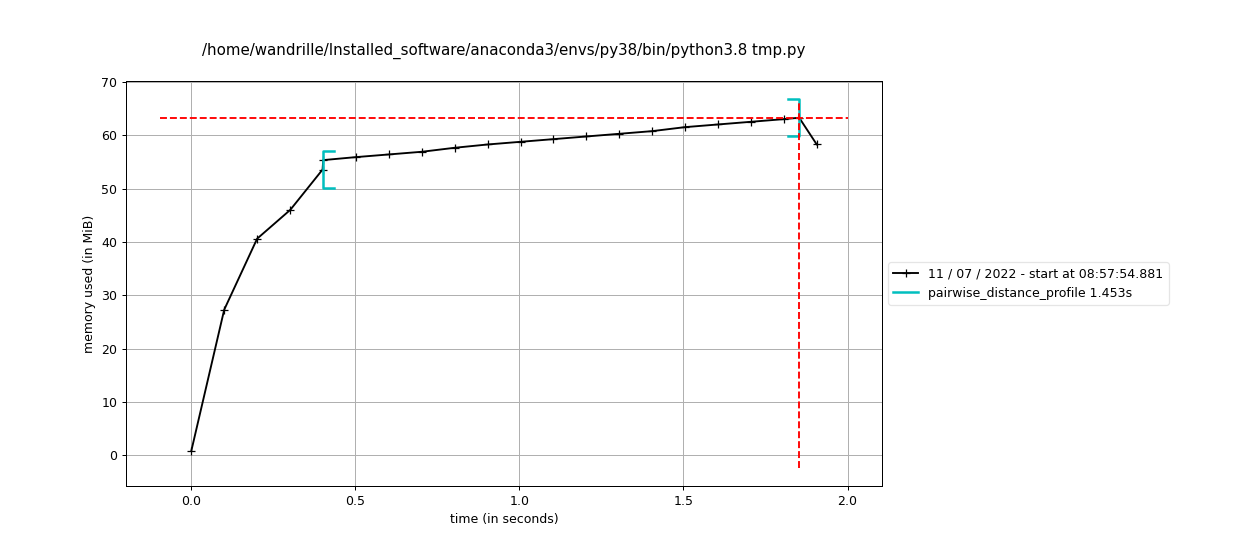

In [116]:
from IPython.display import Image
Image("tmp.png")

Here we clearly see the initial memory loading (linked to the importation of libraries and generation of the data), and the funtion of interest is clearly marked. 
We can see it leads to an increase of RAM usage of about 8MiB.

Also note that the overhead is much lower:

In [111]:
num_vector = 500
num_measures = 10
data = np.random.uniform(size=(num_vector,num_measures))

%time _=pairwise_distance(data)

CPU times: user 1.49 s, sys: 8.02 ms, total: 1.5 s
Wall time: 1.5 s


1.5s, vs. 2.3s with mprof : much more reasonnable

`mprof` is very useful to explore the and pinpoint memory spike, especially since it **works with all executables** and not only python scripts

You can increase the granularity of the report using the `--interval` parameter (default: 0.1s).

`mprof` also has a mode designed to monitor executables using multiprocessing.



<br>

[back to the ToC](#toc)

## 2.3 getting the size of a single object <a id='2.3'></a>

Last but not least, when you know your code enough you can often point to the precise object who represents the majority of RAM usage in your code.

In the case of the script for distance computation between sequences in a fasta file, the error message pinpointed the problematic line:

```python
---------------------------------------------------------------------------
MemoryError                               Traceback (most recent call last)
File <timed eval>:1, in <module>

Input In [59], in mainScript(input_filename, output_filename)
     57 ordered_seq = sorted( Dgc.keys() , key= lambda x : Dgc[x] )
     59 # step 4 : compute pairwise distance matrix
---> 60 sim = np.zeros( ( len(Dseq),len(Dseq) ) )
     61 for i,s1 in enumerate(ordered_seq):
     62     for j,s2 in enumerate(ordered_seq):

MemoryError: Unable to allocate 7.28 TiB for an array with shape (1000000, 1000000) and data type float64
```

So here, no need to use advanced tools : the problem is this square matrix.

We can investigate the memory needed by an object in memory with `sys.getsizeof`.

In [139]:
import sys

a = 0.5 # a simple float
print("size of a float:" , sys.getsizeof(a))

b ="abcdef" # a simple float
print("size of a str:" , sys.getsizeof(b))


size of a float: 24
size of a str: 55


The reported size is in bytes. To get kib: divide by 1024. 

To get MiB, divide by 1024*1024

In [143]:
N = 1000
c = np.zeros((N,N)) #NxN matrix 
print("size of a {}x{} matrix: {:.2f} MiB".format(N,N, sys.getsizeof(c)/(1024*1024)) )

size of a 1000x1000 matrix: 7.63 MiB


A little *caveat* though. Consider the following code: 

In [144]:
import sys

a = 0.5 # a simple float
print("size of a float:" , sys.getsizeof(a))

b = [np.random.random() for i in range(10)]
print("size of a list of 10 floats:" , sys.getsizeof(b))

size of a float: 24
size of a list of 10 floats: 184


See anything strange? 

If a single `float` is 24bytes, then how can a list of 10 floats be less than 10*24=240 bytes ?

<br>

This is because `getsizeof` only account for direct memory does not go follow references to objects. 
In practice, that means it struggles with containers.

The official documentation point to this function if you want to get the total size of an object, including everything it contains or refers to:

In [145]:

from sys import getsizeof, stderr
from itertools import chain
from collections import deque
try:
    from reprlib import repr
except ImportError:
    pass
def total_size(o, handlers={}, verbose=False):
    """ Returns the approximate memory footprint an object and all of its contents.

    Automatically finds the contents of the following builtin containers and
    their subclasses:  tuple, list, deque, dict, set and frozenset.
    To search other containers, add handlers to iterate over their contents:

        handlers = {SomeContainerClass: iter,
                    OtherContainerClass: OtherContainerClass.get_elements}

    """
    dict_handler = lambda d: chain.from_iterable(d.items())
    all_handlers = {tuple: iter,
                    list: iter,
                    deque: iter,
                    dict: dict_handler,
                    set: iter,
                    frozenset: iter,
                   }
    all_handlers.update(handlers)     # user handlers take precedence
    seen = set()                      # track which object id's have already been seen
    default_size = getsizeof(0)       # estimate sizeof object without __sizeof__

    def sizeof(o):
        if id(o) in seen:       # do not double count the same object
            return 0
        seen.add(id(o))
        s = getsizeof(o, default_size)

        if verbose:
            print(s, type(o), repr(o), file=stderr)

        for typ, handler in all_handlers.items():
            if isinstance(o, typ):
                s += sum(map(sizeof, handler(o)))
                break
        return s

    return sizeof(o)

In [146]:
print("total size of a list of 10 floats:" , total_size(b))

total size of a list of 10 floats: 424


So, `getsizeof` returned 184, which is the size of the list, add to this the 10 float : 10*24, and you get
$184+24*10=424$.
It works!

Note that for numpy array this does not change anything (because numpy arrays do not access their data by reference).

In [148]:
print( "array getsizeof :" , sys.getsizeof(c))
print( "array total_size:" , total_size(c)   )

array getsizeof : 8000120
array total_size: 8000120


**micro-exercise:** find out which is the largest square matrix your RAM could reasonably accomodate.

**optional micro-exercise:** how could we modify the `mainScript` to make it less memory hungry?

[back to the ToC](#toc)

# Annex - Kmean implementation profiling:

Imagine you have a script, implementing a Kmeans algorithm. 
Here are the functions which look like the best candidates for optimization :
* `computeDistanceToCentroid` : compute the distance between a poitnand a centroid
* `computeNearestCentroid` : compute which centroid is the closest to each point (actualy calls `computeDistanceToCentroid`, but also possess some other potentially costly computations)
* `computeCentroids` : computes the position of the centroid of a points with a given cluster assignment

Are they really the best candidate ? which one should we go for first ?


In [11]:
# generating some random data 
def generateCluster( n , means , sds ):
    P = np.random.randn( len(means) , n )
    for i in range(len(means)):
        P[i,] = P[i,] * sds[i] + means[i]
    
    return P


clusterSizes = [4000,2000,4000,4000,2000 ]
clusterMeans = [ [ 0 , -2 ] , [ 3 , 3 ] ,[ -1 , 3 ], [-5, 0] , [5,-1] ]
clusterSDs = [ [0.5,1] ,[1,0.5] ,[0.5,0.5],[2,1] ,[1,1] ]
C = []
A = []
for i in range( len(clusterSizes) ):
    C.append( generateCluster( clusterSizes[i] , clusterMeans[i] , clusterSDs[i] ) )
    A += [i]*clusterSizes[i]
Points = np.concatenate( C , axis=1)
realAssignment = np.array(A)


In [12]:
from Kmeans import Kmeans
# performing Kmean
k=5
%prun -l 30 -s cumtime  kmeanAssignment = Kmeans( Points , k , maxNbRounds=1000 ) 
# the %prun magic command activate profiling
#  -l 30 : limits the report to 30 lines
#  -s cumtime : sort by decreasing cumtime
